# VS Ensemble Dockig CDK2
## Análisis de datos exploratorio

- 111 ligandos
    - 27 Activos
- 402 Conformaciones de la porteína CDK2
    - Conformaciones experimentales
- 3 progrmas de acoplamiento molecular

### Contenido:
- Pendiente agregar las secciones

In [3]:
import pandas as pd 
import numpy as np 

### Carga de los datos

In [4]:
# Directorio
data_dir = './data'
# Carga de los dataFrames
# Autodock 4. LE (lowest energy), LC (largest Cluster)
df_ad4_results_LE = pd.read_csv(F'{data_dir}/vs_docking_crys_ensemble_AD4_LE.csv', index_col=0)
df_ad4_results_LC = pd.read_csv(F'{data_dir}/vs_docking_crys_ensemble_AD4_LC.csv', index_col=0)
# Autodock Vina
df_vina_results = pd.read_csv(F'{data_dir}/vs_docking_crys_ensemble_VINA.csv', index_col=0)
# Vinardo scoring
df_vinardo_results = pd.read_csv(F'{data_dir}/vs_docking_crys_ensemble_VINARDO.csv', index_col=0)

Todas los dataFrames poseen 111 filas (111 ligandos) y 403 columnas, correspondientes a la etiqueta de actividad/inactividad, y a las 402 conformaciones. 

### Datos CDK2 de CSAR
Las etiquetas de actividad y la información sobre los 111 ligandos se encuentran en el siguiente [enlace](https://drugdesigndata.org/about/datasets/220).

### Comenzamos el análisis de los datos

In [5]:
# Identificamos a los ligandos que son activos
activos =  df_vina_results.ActiveInactive == "Active"

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Definimos una función para graficar boxplots
def plot_boxplot_dock_results(df, titulo=''):
    '''Función para graficar boxplots de los resultados de acoplamiento molecular'''
    num_ligs, num_conf = df.iloc[:, 2:-1].shape
    fig, ax = plt.subplots(figsize =(20, 5))
    sns.set_style("white"); sns.set_context("paper")
    ax.axvspan(0, 3, color=sns.xkcd_rgb['grey'], alpha=0.3)
    ax.axvspan(5, 16, color=sns.xkcd_rgb['grey'], alpha=0.3)
    ax.axvspan(101, 110, color=sns.xkcd_rgb['grey'], alpha=0.3)
    sns.boxplot(ax = ax,  data = df.iloc[:, 2:-1].T )
    plt.title(F"{titulo}: Boxplots - {num_ligs} ligandos - {num_conf} conformaciones", size = 20)
    plt.xticks(rotation=90, size=11)
    ax.set_ylabel(F'{titulo} Score (kcal/mol)', fontsize=18)
    ax.set_xlabel('Ligandos CSAR', fontsize=18)
    plt.show()

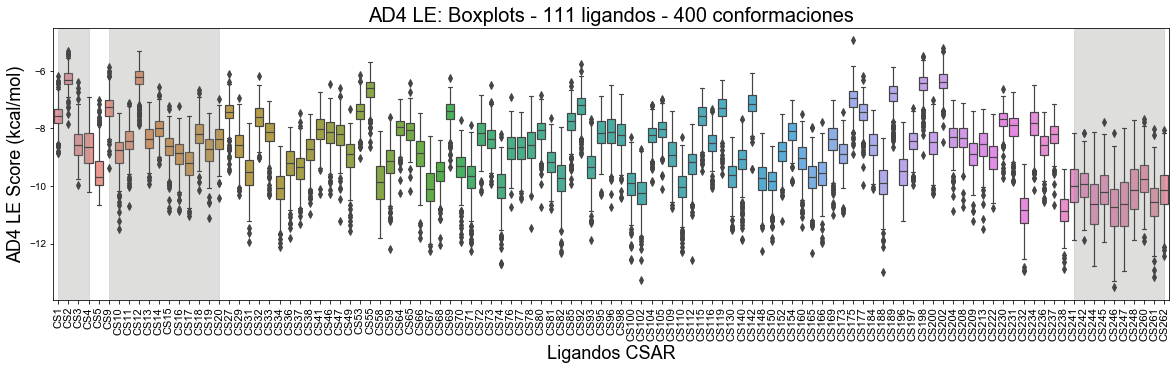

In [9]:
plot_boxplot_dock_results(df_ad4_results_LE, titulo="AD4 LE")

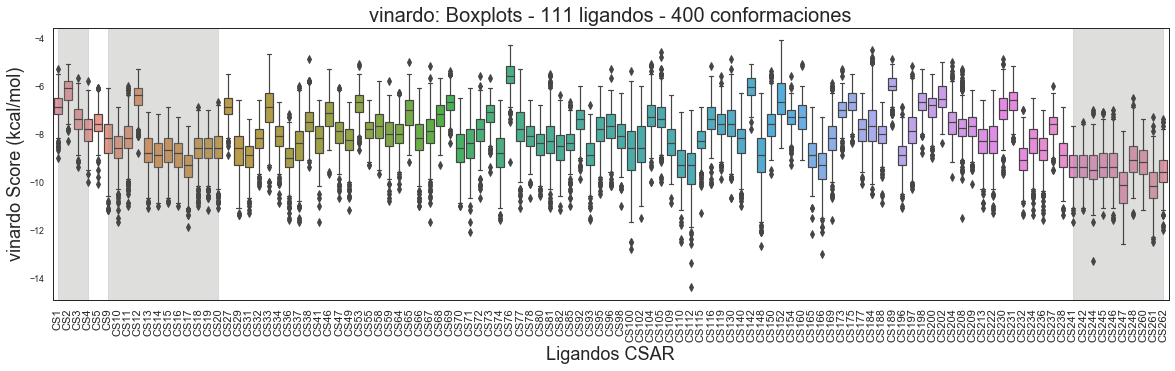

In [10]:
plot_boxplot_dock_results(df_vinardo_results, titulo="vinardo")

En cada gráfica, se muestran los 111 ligandos y sus scores para cada una de las 402 conformaciones de la proteína.

# Curvas ROC

In [7]:
# Librerías para calcular las ROC y el AUC
from sklearn.metrics import roc_curve, roc_auc_score

Etiquetas de los ligandos, **1 = Activo**.

In [8]:
true_values = np.array(df_vina_results.ActiveInactive == "Active", dtype=int)
print(true_values)

[1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]


Calculamos el **AUC** tomando en cuenta los *rankings* de cada programa de *docking* a partir del promedio de los ranking por conformación.

In [9]:
sc_promedio_vrd = np.array(df_vinardo_results.mean(axis=1))
sc_promedio_vina = np.array(df_vina_results.mean(axis=1))
sc_promedio_ad4_LE = np.array(df_ad4_results_LE.mean(axis=1))
sc_promedio_ad4_LC = np.array(df_ad4_results_LC.mean(axis=1))

**Curvas ROC:**

In [10]:
print('AUC del valor PROMEDIO (402 estructuras):')
print("AD4 LE:", 
        roc_auc_score( y_true = true_values, y_score = (- sc_promedio_ad4_LE)) )        
print("AD4 LC:", 
        roc_auc_score( y_true = true_values, y_score = (- sc_promedio_ad4_LC)) )
print("Vina 16x:", 
        roc_auc_score( y_true = true_values, y_score = (- sc_promedio_vina)) )
print("Vinardo 16x:", 
        roc_auc_score( y_true = true_values, y_score = (- sc_promedio_vrd)) )   

AUC del valor PROMEDIO (402 estructuras):
AD4 LE: 0.5941176470588236
AD4 LC: 0.6900452488687783
Vina 16x: 0.5524886877828055
Vinardo 16x: 0.7610859728506787


**Gráficas de las ROC.**

In [11]:
# Establecemos los parámetros para graficar
import pylab
pylab.rcParams['figure.figsize'] = (7, 7)
sns.set( context = 'talk', style = 'white', palette = "Set2")

def add_plot_roc(predicted_values, true_values, label = ''):
    inverted_input = np.negative(predicted_values)
    fpr, tpr, thresholds = roc_curve(true_values, inverted_input)
    auc = roc_auc_score( y_true = true_values, y_score = inverted_input)
    plt.plot(fpr, tpr, label= label + ' AUC = %0.2f' % auc, lw = 4)

def plot_roc(predicted_values, true_values, label = '', titulo = "ROC curve"):
    sns.color_palette("Paired")
    add_plot_roc(predicted_values, true_values, label)
    plt.legend()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("FPR (1 - specificity)")
    plt.ylabel("TPR (sensitivity)")
    plt.grid(linestyle='--', linewidth='0.8')
    plt.title(titulo)
    plt.show()

### ROC con valores promedio (Rank-by-number)
Gráfica **ROC** con valores promedio.
> El score de cada ligando corresponde al *score* promedio de cada ligando en todas las conformaciones:  
$RbNi$

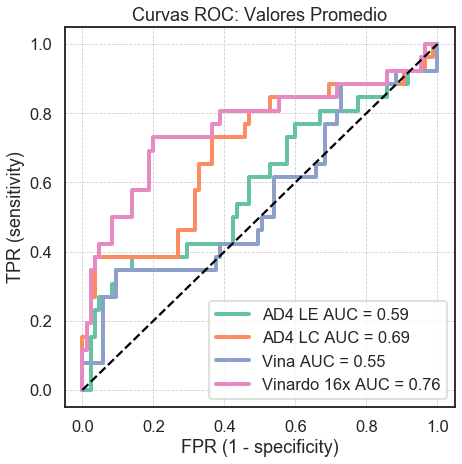

In [12]:
add_plot_roc(sc_promedio_ad4_LE, true_values, "AD4 LE")
add_plot_roc(sc_promedio_ad4_LC, true_values, "AD4 LC")
add_plot_roc(sc_promedio_vina, true_values, "Vina")
#add_plot_roc(sc_promedio_vrd_8x, true_values, "Vinardo 8x")
plot_roc(sc_promedio_vrd, true_values, "Vinardo 16x", "Curvas ROC: Valores Promedio")

### ROC con mejores *scores* de cada método
Gráficas **ROC**, si para el **ranking** final extrajeramos el mejor score de cada ligando.

In [13]:
# Scorings mínimos (mejores) de cada ligando
sc_minimo_vrd = np.array(df_vinardo_results.min(axis=1))
sc_minimo_vina = np.array(df_vina_results.min(axis=1))
sc_minimo_ad4_LE = np.array(df_ad4_results_LE.min(axis=1))
sc_minimo_ad4_LC = np.array(df_ad4_results_LC.min(axis=1))

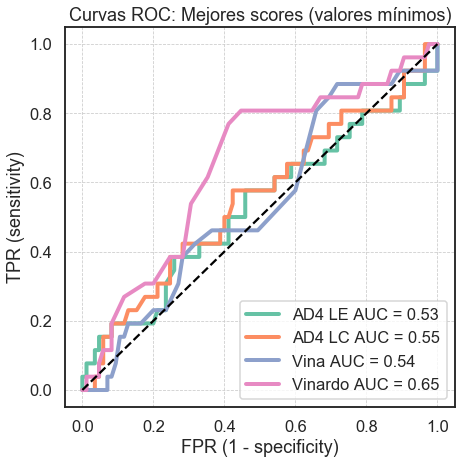

In [14]:
add_plot_roc(sc_minimo_ad4_LE, true_values, "AD4 LE")
add_plot_roc(sc_minimo_ad4_LC, true_values, "AD4 LC")
add_plot_roc(sc_minimo_vina, true_values, "Vina")
plot_roc(sc_minimo_vrd, true_values, "Vinardo", "Curvas ROC: Mejores scores (valores mínimos)")

### ROC *rank-by-rank*
$R_bR_i = \frac{1}{n}\sum_jr_i^j$

In [15]:
def get_rank_by_rank(df):
    df_ranks = df.rank() # Obtenemos los rankings de cada ligando
    # Para cada ligando i se suman sus valores de ranking y se divide entre el número de conformaciones
    df_rank_by_rank = np.array(df_ranks.sum(axis=1)/df_ranks.shape[1])
    return(df_rank_by_rank)

In [16]:
r_by_r_vrd = get_rank_by_rank(df_vinardo_results.drop(['ActiveInactive'], axis = 1))
r_by_r_vina = get_rank_by_rank(df_vina_results.drop(['ActiveInactive'], axis = 1))
r_by_r_ad4_LE = get_rank_by_rank(df_ad4_results_LE.drop(['ActiveInactive'], axis = 1))
r_by_r_ad4_LC = get_rank_by_rank(df_ad4_results_LC.drop(['ActiveInactive'], axis = 1))

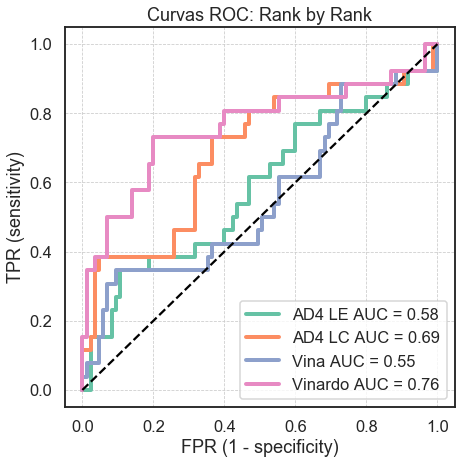

In [17]:
add_plot_roc(r_by_r_ad4_LE, true_values, "AD4 LE")
add_plot_roc(r_by_r_ad4_LC, true_values, "AD4 LC")
add_plot_roc(r_by_r_vina, true_values, "Vina")
plot_roc(r_by_r_vrd, true_values, "Vinardo", "Curvas ROC: Rank by Rank")

### ROC z-score

In [28]:
def get_zscore(df):
    means = df.mean(axis=0)
    stds = df.std(axis=0)
    df_centered_values = (df - means)/stds
    z_score =  df_centered_values.mean(axis=1)
    return(z_score)

In [29]:
z_score_vrd = get_zscore(df_vinardo_results.drop(['ActiveInactive'], axis = 1))
z_score_vina = get_zscore(df_vina_results.drop(['ActiveInactive'], axis = 1))
z_score_ad4_LE = get_zscore(df_ad4_results_LE.drop(['ActiveInactive'], axis = 1))
z_score_ad4_LC = get_zscore(df_ad4_results_LC.drop(['ActiveInactive'], axis = 1))

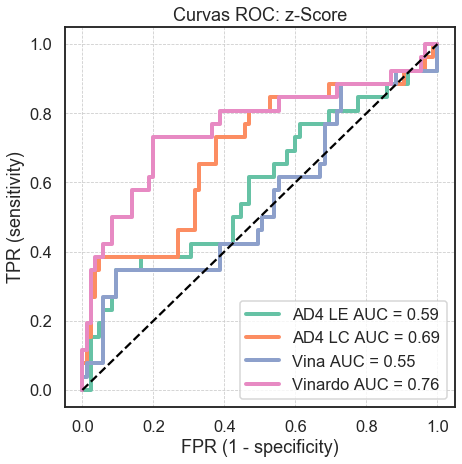

In [30]:
add_plot_roc(z_score_ad4_LE, true_values, "AD4 LE")
add_plot_roc(z_score_ad4_LC, true_values, "AD4 LC")
add_plot_roc(z_score_vina, true_values, "Vina")
plot_roc(z_score_vrd, true_values, "Vinardo", "Curvas ROC: z-Score")

### ROC con *ranking* de una conformación
Curva ROC a partir del *ranking* de una conformación dada: "**1aq1**"

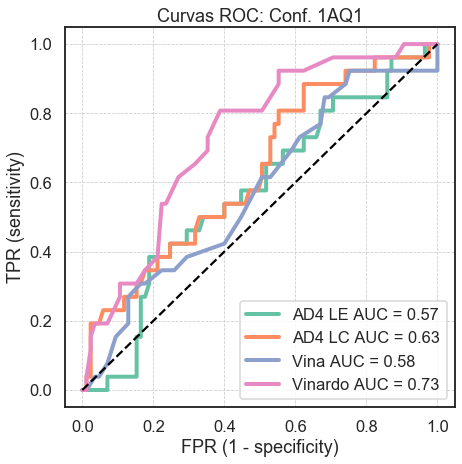

In [31]:
# Curva ROC dada una conformación
pdb_id = "1aq1"
add_plot_roc(df_ad4_results_LE[ pdb_id ], true_values, "AD4 LE")
add_plot_roc(df_ad4_results_LC[ pdb_id ], true_values, "AD4 LC")
add_plot_roc(df_vina_results[ pdb_id ], true_values, "Vina")
plot_roc(df_vinardo_results[ pdb_id ], true_values, "Vinardo", F"Curvas ROC: Conf. {pdb_id.upper()}")

## Calculamos el AUC para todas las conformarmaciones
Se realiza el cálculo del AUC de todas las conformaciones tomando en cuenta los 4 DataFrames de *scores* disponibles.

In [32]:
# Calculo del AUC por conformaión
# carga del dataFrame con la información general de las estructuras cristalográficas
df_cdk2_labels = pd.read_json(F"{data_dir}/TABLA_MTDATA_CDK2_402_crys_LIGS_INFO_LABELS.json")
#df_cdk2_labels.head(3)

**Cálculo de AUC para cada conformación.**

In [34]:
df_cdk2_labels["AUC_vrd_16x"] = 0.0
df_cdk2_labels["AUC_vrd_8x"] = 0.0
df_cdk2_labels["AUC_vina"] = 0.0
df_cdk2_labels["AUC_ad4_LC"] = 0.0
for pdb in df_cdk2_labels.index:
    # Vinardo 16x
    roc_vrd = roc_auc_score(np.array(true_values), - df_vinardo_results[ pdb ])
    df_cdk2_labels.at[ pdb, "AUC_vrd_16x"] = roc_vrd
    # Vina 16x
    roc_vina = roc_auc_score(np.array(true_values), - df_vina_results[ pdb ])
    df_cdk2_labels.at[ pdb, "AUC_vina"] = roc_vina
    # Autodock 4: LE
    roc_ad4_LE = roc_auc_score(np.array(true_values), - df_ad4_results_LE[ pdb ])
    df_cdk2_labels.at[ pdb, "AUC_ad4_LE"] = roc_ad4_LE
    # Autodock 4: LC
    roc_ad4_LC = roc_auc_score(np.array(true_values), - df_ad4_results_LC[ pdb ])
    df_cdk2_labels.at[ pdb, "AUC_ad4_LC"] = roc_ad4_LC

In [35]:
df_cdk2_labels.iloc[:, -8:].head(3)

,Inhib,Inhib_mass,Labels_conf,AUC_vrd_16x,AUC_vrd_8x,AUC_vina,AUC_ad4_LC,AUC_ad4_LE
1aq1,STU,440.0,inact_b,0.730317,0.0,0.575339,0.634163,0.572172
1b38,ATP,398.0,inact_a,0.677828,0.0,0.546154,0.571946,0.483032
1b39,ATP,398.0,inact_a,0.764706,0.0,0.580543,0.670814,0.607919


### Guardamos el dataFrame

In [36]:
# Guardamos el dataframe
# df_cdk2_labels.to_json(F"{data_dir}/TABLA_MTDATA_CDK2_402_crys_LIGS_INFO_LABELS_AUC_docking.json")

## Conformaciones con mejor AUC por Método de score
### ROC con *ranking* de la MEJOR conformación en Vinardo a 16x
Curva ROC a partir del *ranking* de la mejor conformación con Vinardo (conformación con mejor AUC de vinardo).

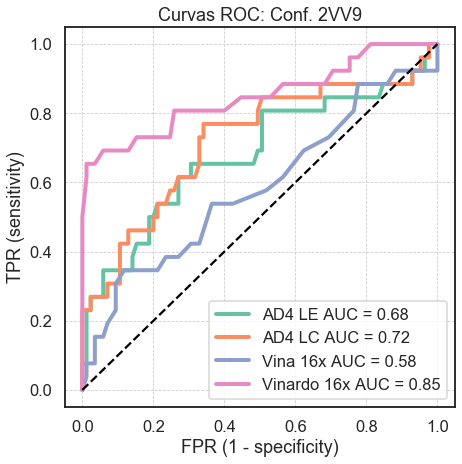

In [37]:
# ROC de la mejor conformación de vinardo
pdb_id = df_cdk2_labels[["AUC_vrd_16x"]].idxmax()[0]

add_plot_roc(df_ad4_results_LE[ pdb_id ], true_values, "AD4 LE")
add_plot_roc(df_ad4_results_LC[ pdb_id ], true_values, "AD4 LC")
add_plot_roc(df_vina_results[ pdb_id ], true_values, "Vina 16x")
plot_roc(df_vinardo_results[ pdb_id ], true_values, "Vinardo 16x", F"Curvas ROC: Conf. {pdb_id.upper()}")

### ROC con *ranking* de la MEJOR conformación en Vinardo a 8x

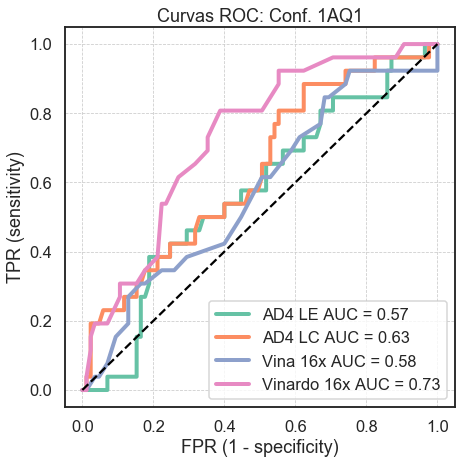

In [38]:
# ROC de la mejor conformación de vinardo a 8x
pdb_id = df_cdk2_labels[["AUC_vrd_8x"]].idxmax()[0]

add_plot_roc(df_ad4_results_LE[ pdb_id ], true_values, "AD4 LE")
add_plot_roc(df_ad4_results_LC[ pdb_id ], true_values, "AD4 LC")
add_plot_roc(df_vina_results[ pdb_id ], true_values, "Vina 16x")
plot_roc(df_vinardo_results[ pdb_id ], true_values, "Vinardo 16x", F"Curvas ROC: Conf. {pdb_id.upper()}")

### ROC con ranking de la MEJOR conformación en Vina a 16x

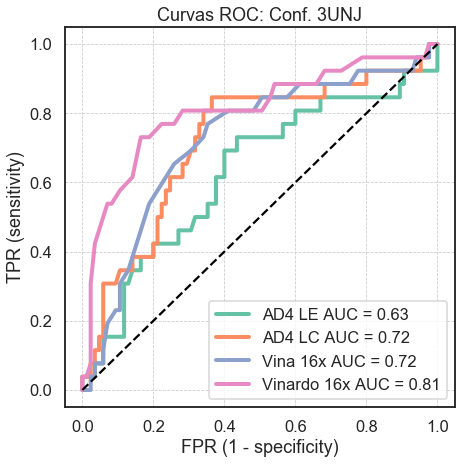

In [39]:
# ROC de la mejor conformación de vina a 16x
pdb_id = df_cdk2_labels[["AUC_vina"]].idxmax()[0]

add_plot_roc(df_ad4_results_LE[ pdb_id ], true_values, "AD4 LE")
add_plot_roc(df_ad4_results_LC[ pdb_id ], true_values, "AD4 LC")
add_plot_roc(df_vina_results[ pdb_id ], true_values, "Vina 16x")
plot_roc(df_vinardo_results[ pdb_id ], true_values, "Vinardo 16x", F"Curvas ROC: Conf. {pdb_id.upper()}")

### ROC con ranking de la MEJOR conformación en AD4 LC

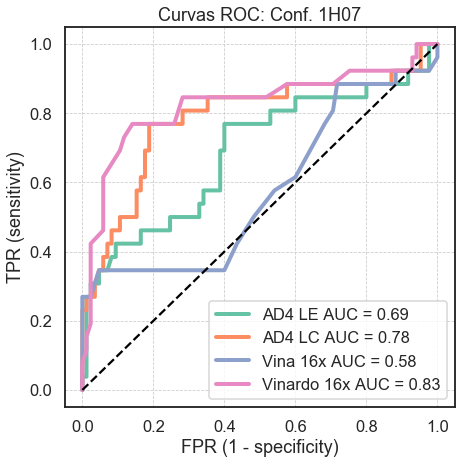

In [40]:
# ROC de la mejor conformación de ad4 LC
pdb_id = df_cdk2_labels[["AUC_ad4_LC"]].idxmax()[0]

add_plot_roc(df_ad4_results_LE[ pdb_id ], true_values, "AD4 LE")
add_plot_roc(df_ad4_results_LC[ pdb_id ], true_values, "AD4 LC")
add_plot_roc(df_vina_results[ pdb_id ], true_values, "Vina 16x")
plot_roc(df_vinardo_results[ pdb_id ], true_values, "Vinardo 16x", F"Curvas ROC: Conf. {pdb_id.upper()}")

### ROC con ranking de la MEJOR conformación en AD4 LE

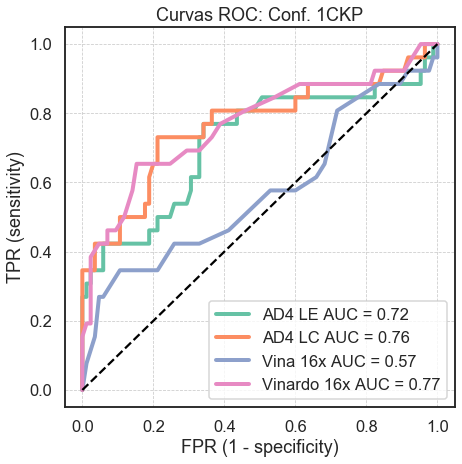

In [41]:
# ROC de la mejor conformación de ad4 LC
pdb_id = df_cdk2_labels[["AUC_ad4_LE"]].idxmax()[0]

add_plot_roc(df_ad4_results_LE[ pdb_id ], true_values, "AD4 LE")
add_plot_roc(df_ad4_results_LC[ pdb_id ], true_values, "AD4 LC")
add_plot_roc(df_vina_results[ pdb_id ], true_values, "Vina 16x")
plot_roc(df_vinardo_results[ pdb_id ], true_values, "Vinardo 16x", F"Curvas ROC: Conf. {pdb_id.upper()}")

## Distribución de AUC por programa de *docking*
### *Violin plots*

In [42]:
# Seleccionamos las columnas que poseen los scores para cada método usado
df_auc_scores = df_cdk2_labels[['AUC_ad4_LE', 'AUC_ad4_LC', 
                'AUC_vina', 'AUC_vrd_16x']]

## Valor de AUC por scoring vs conformación
**Se comparar únicamente los resultados en la evaluación con el set de CSAR**

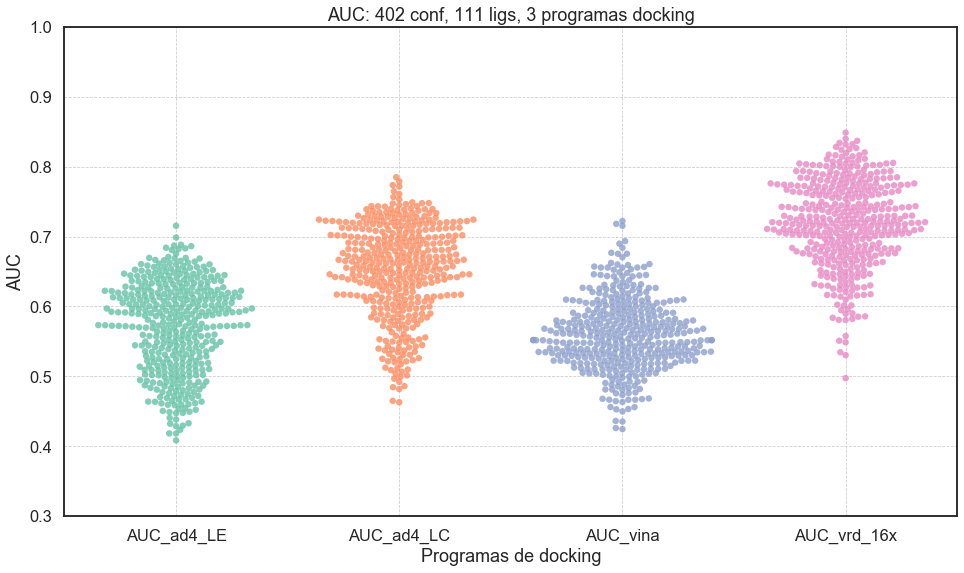

In [43]:
fig, axes = plt.subplots()

cmp = sns.set_palette(['#fa9a58',  '#cf384d', '#93d067',  '#3498db'])
data = df_auc_scores
data = data.melt()
data['Conf Labels'] = np.tile(df_cdk2_labels.Labels_conf, 4)

fig.set_size_inches(16, 9)
sns.swarmplot(x = "variable", y = "value", data= data, ax = axes, alpha=0.8, 
               palette=  'Set2', s = 6.5)
axes.set_title('AUC: 402 conf, 111 ligs, 3 programas docking')
axes.grid(linestyle='--', linewidth='0.8')
plt.xlabel("Programas de docking")
plt.ylabel("AUC")
plt.ylim(0.3, 1)
plt.show()
#plt.savefig("ROC_402_conformations.pdf", format="pdf")

### Mejores conformaciones de Vinardo (AUC de >0.8)

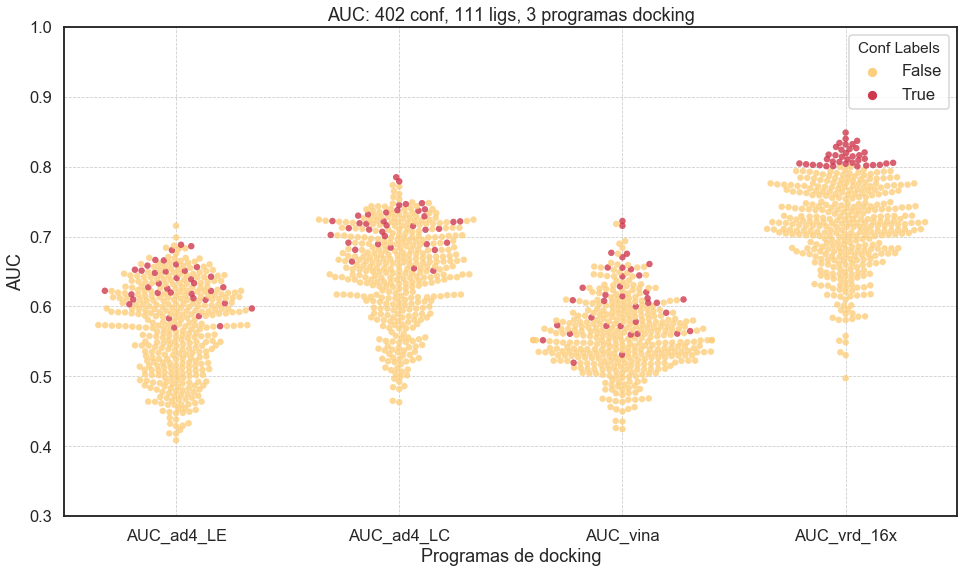

In [274]:
fig, axes = plt.subplots()

cmp = sns.set_palette(['#fdce7c', '#cf384d', 'green', '#93d067',  '#3498db'])
data = df_auc_scores
data = data.melt()
data['Conf Labels'] = np.tile(df_cdk2_labels.AUC_vrd_16x > 0.8, 4)

fig.set_size_inches(16, 9)
sns.swarmplot(x = "variable", y = "value", data= data, ax = axes, alpha=0.8, 
              hue = "Conf Labels", palette= cmp, s = 6.5)
axes.set_title('AUC: 402 conf, 111 ligs, 3 programas docking')
axes.grid(linestyle='--', linewidth='0.8')
plt.xlabel("Programas de docking")
plt.ylabel("AUC")
plt.ylim(0.3, 1)
#plt.show()
plt.savefig("ROC_402_conformations.pdf", format="pdf")

### Etiquetado de las conforamciones según su estado Activo/Inactivo

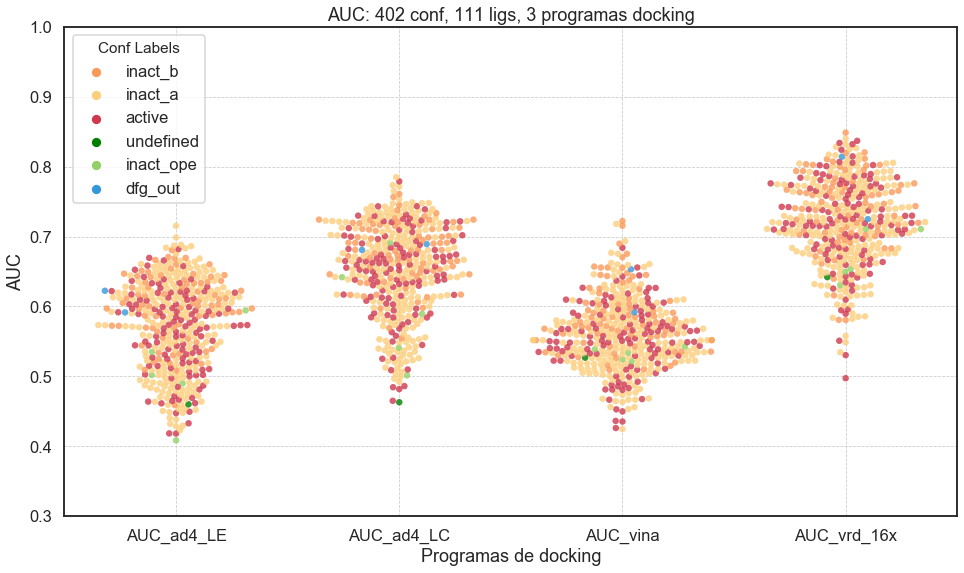

In [161]:
fig, axes = plt.subplots()

cmp = sns.set_palette(['#fa9a58', '#fdce7c', '#cf384d', 'green', '#93d067',  '#3498db'])
data = df_auc_scores
data = data.melt()
data['Conf Labels'] = np.tile(df_cdk2_labels.Labels_conf, 4)

fig.set_size_inches(16, 9)
sns.swarmplot(x = "variable", y = "value", data= data, ax = axes, alpha=0.8, 
              hue = "Conf Labels", palette= cmp, s = 6.5)
axes.set_title('AUC: 402 conf, 111 ligs, 3 programas docking')
axes.grid(linestyle='--', linewidth='0.8')
plt.xlabel("Programas de docking")
plt.ylabel("AUC")
plt.ylim(0.3, 1)
#plt.show()
plt.savefig("ROC_402_conformations.pdf", format="pdf")

## Comparación por otras propidades de las conformaciones
### Conformaciones según la resolución del cristal

In [56]:
df_cdk2_labels.Resolution.describe()

count    402.000000
mean       2.023657
std        0.408628
min        0.980000
25%        1.800000
50%        1.990000
75%        2.247500
max        3.500000
Name: Resolution, dtype: float64

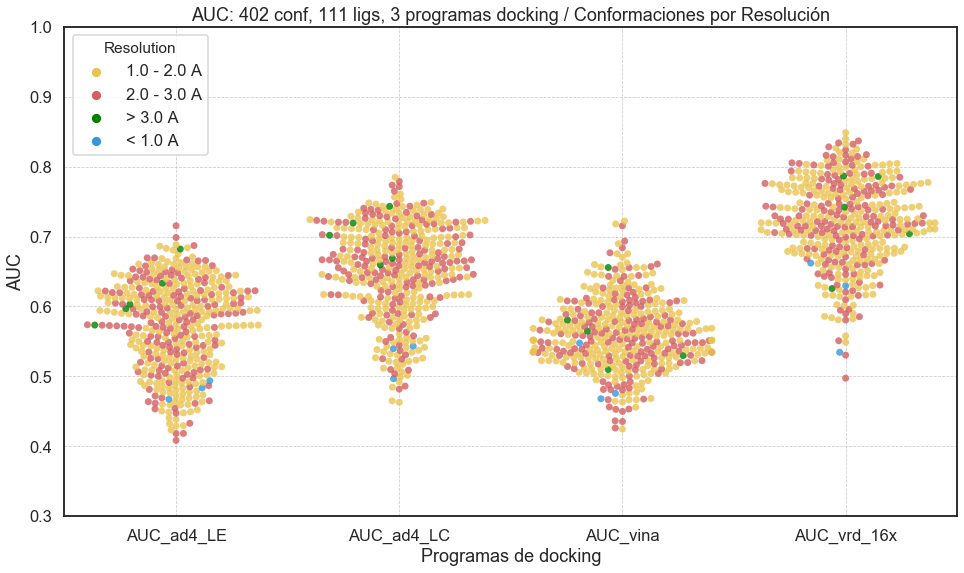

In [162]:
# Por  resoluciones de las conformaciones
resolution = ["< 1.0 A" if i <= 1.0
              else "1.0 - 2.0 A" if i <= 2
              else "2.0 - 3.0 A" if i <= 3
              else "> 3.0 A"
              for i in df_cdk2_labels.Resolution]

fig, axes = plt.subplots()

cmp = sns.set_palette(['#EAC350',  '#D55E5E', 'green',  '#3498db'])
data = df_auc_scores
data = data.melt()
data['Resolution'] = np.tile(resolution, 4)

fig.set_size_inches(16, 9)
sns.swarmplot(x = "variable", y = "value", data= data, ax = axes, alpha=0.8, 
              hue = "Resolution", palette= cmp, s = 7)
axes.set_title('AUC: 402 conf, 111 ligs, 3 programas docking / Conformaciones por Resolución')
axes.grid(linestyle='--', linewidth='0.8')
plt.xlabel("Programas de docking")
plt.ylabel("AUC")
plt.ylim(0.3, 1)
plt.show()

### Por cobertura de secuencia en la estructura cristalográfica

In [65]:
df_cdk2_labels.Coverage.describe()

count    402.000000
mean      97.065011
std        2.788320
min       86.577181
25%       94.966443
50%       97.986577
75%       99.328859
max      102.013423
Name: Coverage, dtype: float64

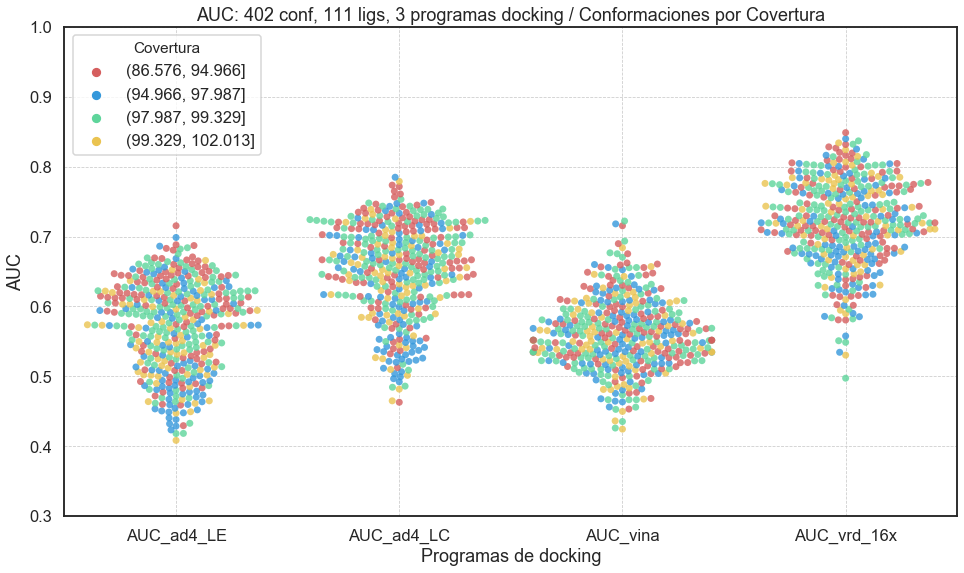

In [163]:
# por covertura de las Conformaciones
# Por  resoluciones de las conformaciones
covertura = pd.qcut(df_cdk2_labels.Coverage, 4)


fig, axes = plt.subplots()

cmp = sns.set_palette(['#D55E5E', '#3498db',  '#5ED59B', '#EAC350'])
data = df_auc_scores
data = data.melt()
data['Covertura'] = np.tile(covertura, 4)

fig.set_size_inches(16, 9)
sns.swarmplot(x = "variable", y = "value", data= data, ax = axes, alpha=0.8, 
              hue = "Covertura", palette= cmp, s = 7)
axes.set_title('AUC: 402 conf, 111 ligs, 3 programas docking / Conformaciones por Covertura')
axes.grid(linestyle='--', linewidth='0.8')
plt.xlabel("Programas de docking")
plt.ylabel("AUC")
plt.ylim(0.3, 1)
plt.show()

### Por volumen de la cavidad

In [141]:
# Cargamos los valores del volumen del pocket
col_names = ['frame', 'pocket_volume']
volumen_402_stc = pd.read_csv('../ARCHIVOS/CRISTALES/VOLUMEN/CDK2_VOL_RICCI_402/res_volumes.tabbed.txt', 
                              sep = "\t", header=None, names= col_names)

In [142]:
volumen_402_stc[['pocket_volume']].describe()

,pocket_volume
count,402.000000
mean,779.631841
std,138.063446
min,405.000000
25%,684.250000
50%,760.000000
75%,843.750000
max,1534.000000


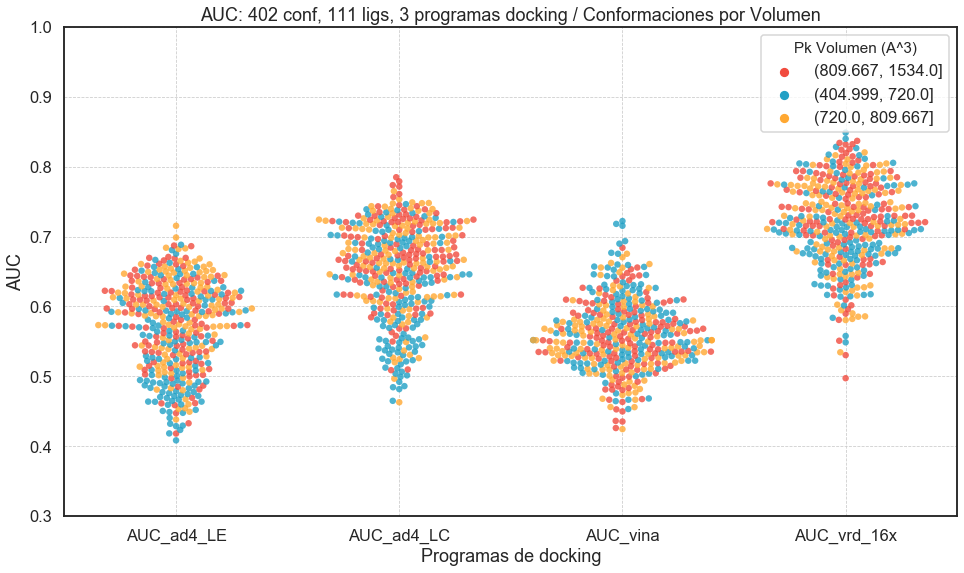

In [237]:
volumen = pd.qcut(volumen_402_stc.pocket_volume, 3)

fig, axes = plt.subplots()

cmp = sns.set_palette(['#F14B3E', '#21A0C5', '#FFA832'])
data = df_auc_scores
data = data.melt()
data['Pk Volumen (A^3)'] = np.tile(volumen, 4)

fig.set_size_inches(16, 9)
sns.swarmplot(x = "variable", y = "value", data= data, ax = axes, alpha=0.8, 
              hue = 'Pk Volumen (A^3)', palette= cmp, s = 6.5)
axes.set_title('AUC: 402 conf, 111 ligs, 3 programas docking / Conformaciones por Volumen')
axes.grid(linestyle='--', linewidth='0.8')
plt.xlabel("Programas de docking")
plt.ylabel("AUC")
plt.ylim(0.3, 1)
plt.show()

### Conformaciones por cluster según su cavidad
**Propiedad medida con POVME**

In [46]:
# por cluster de pocket
cluster_members_file = '../ARCHIVOS/CRISTALES/VOLUMEN/CDK2_VOL_PISANI_402/res_frameInfo/cluster_members.csv'
with open(cluster_members_file) as f:
    lines = f.readlines()

dic_cluster_pockets = {}
for i, line in enumerate(lines):
    split_line = line.replace('\n', '').split(' ')
    dic_cluster_pockets[F'cluster_{i+1}'] = ([ int(element.split('__')[-1]) -1 for element in split_line])
    
df_cdk2_labels['pocket_cluster'] = 0
# Llenamos la columna
df_cdk2_labels.reset_index(inplace=True)
for key in dic_cluster_pockets.keys():
    for value in dic_cluster_pockets[key]:
        df_cdk2_labels.at[value, 'pocket_cluster'] = int(key.split('_')[-1])

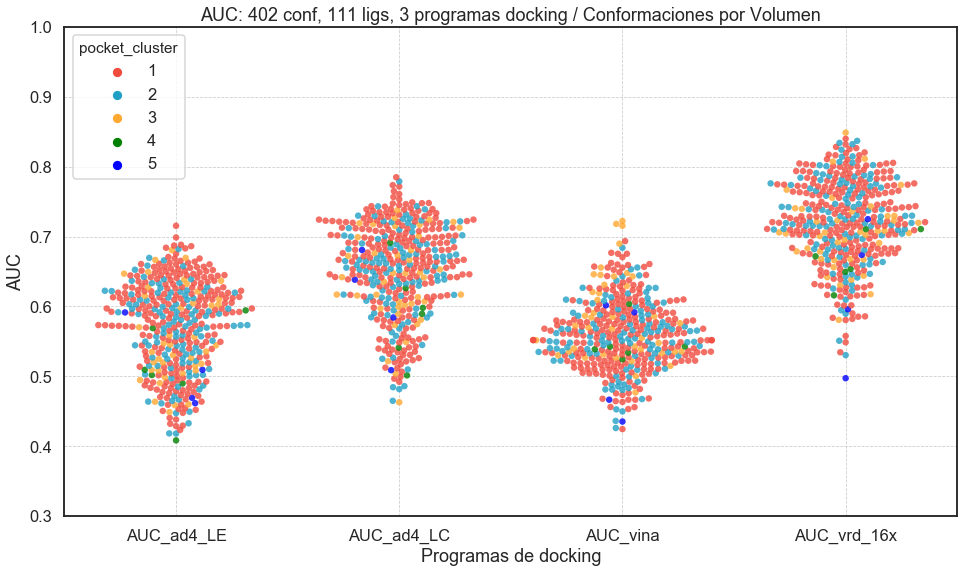

In [47]:
fig, axes = plt.subplots()

cmp = sns.set_palette(['#F14B3E', '#21A0C5', '#FFA832', 'green', 'blue'])
data = df_auc_scores
data = data.melt()
data['pocket_cluster'] = np.tile(df_cdk2_labels['pocket_cluster'], 4)

fig.set_size_inches(16, 9)
sns.swarmplot(x = "variable", y = "value", data= data, ax = axes, alpha=0.8, 
              hue = 'pocket_cluster', palette= cmp, s = 6.5)
axes.set_title('AUC: 402 conf, 111 ligs, 3 programas docking / Conformaciones por Volumen')
axes.grid(linestyle='--', linewidth='0.8')
plt.xlabel("Programas de docking")
plt.ylabel("AUC")
plt.ylim(0.3, 1)
plt.show()

### Conformaciones por masa del ligando
**Conformaciones según la masa del ligando acoplado en el sitio activo, conforamciones sin ligando la masa = 0.**

In [48]:
df_cdk2_labels.Inhib_mass.replace("", 0, inplace=True)
pd.to_numeric(df_cdk2_labels.Inhib_mass).describe()

count    402.000000
mean     285.216418
std      115.075581
min        0.000000
25%      238.000000
50%      306.000000
75%      366.000000
max      462.000000
Name: Inhib_mass, dtype: float64

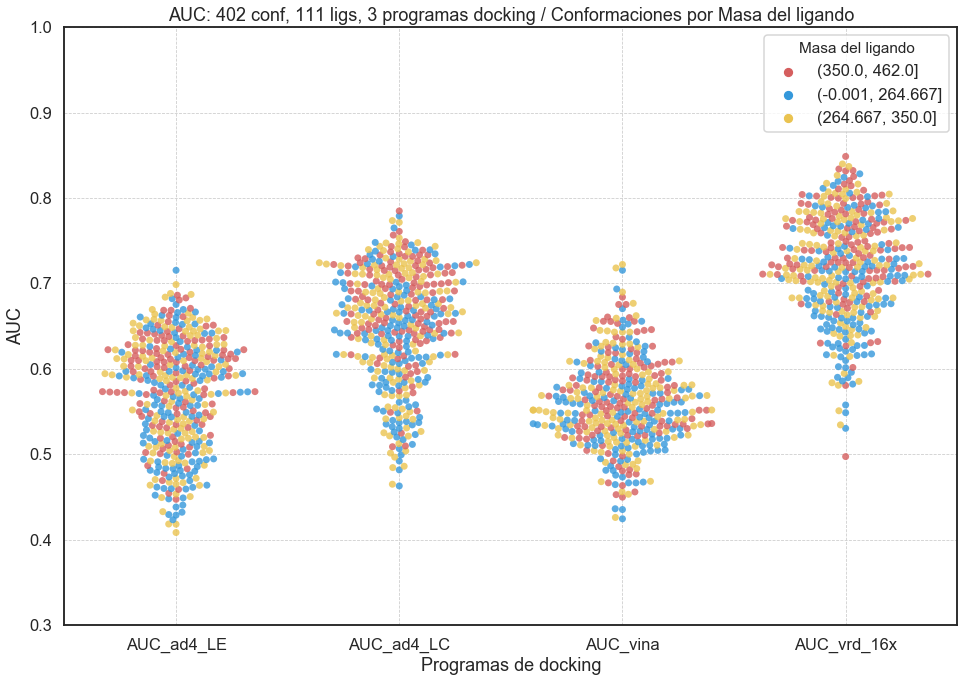

In [53]:
masa_ligando = pd.qcut(pd.to_numeric(df_cdk2_labels.Inhib_mass), 3)

fig, axes = plt.subplots()

cmp = sns.set_palette(['#D55E5E', '#3498db', '#EAC350'])
data = df_auc_scores
data = data.melt()
data['Masa del ligando'] = np.tile(masa_ligando, 4)

fig.set_size_inches(16, 11)
sns.swarmplot(x = "variable", y = "value", data= data, ax = axes, alpha=0.8, 
              hue = "Masa del ligando", palette= cmp, s = 7)
axes.set_title('AUC: 402 conf, 111 ligs, 3 programas docking / Conformaciones por Masa del ligando')
axes.grid(linestyle='--', linewidth='0.8')
plt.xlabel("Programas de docking")
plt.ylabel("AUC")
plt.ylim(0.3, 1)
plt.show()

## Análisis estadístico de la distribución de valores AUC por método de docking

In [60]:
# Evaluamos la normalidad de los datos
import pylab
import scipy.stats as stats
import statsmodels.api as sm

In [58]:
df_auc_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
AUC_ad4_LE,402.0,0.571919,0.064531,0.408371,0.522002,0.583484,0.621719,0.715385
AUC_ad4_LC,402.0,0.651196,0.066604,0.462896,0.611595,0.661538,0.702149,0.784842
AUC_vina,402.0,0.560658,0.051570,0.424434,0.527376,0.557240,0.591968,0.722172
AUC_vrd_16x,402.0,0.719259,0.061990,0.497285,0.680769,0.720814,0.768269,0.848643


### Normalidad de los datos
#### Datos crudos

In [69]:
# Normalidad de los datos
for test in df_auc_scores.columns:
    norm_t = stats.shapiro(df_auc_scores[test])
    print(F'{test}:\t W = {round(norm_t[0], 3)}  p = {round(norm_t[1], 5)}')

AUC_ad4_LE:	 W = 0.973  p = 0.0
AUC_ad4_LC:	 W = 0.965  p = 0.0
AUC_vina:	 W = 0.993  p = 0.04831
AUC_vrd_16x:	 W = 0.982  p = 6e-05


#### Datos estandarizados

In [155]:
# Normalidad de los datos estandarizados
from sklearn.preprocessing import StandardScaler

df_std_auc_values = pd.DataFrame(StandardScaler().fit_transform(df_auc_scores), 
                                 columns= df_auc_scores.columns)

for test in df_auc_scores.columns:
    norm_t = stats.shapiro( df_std_auc_values[test])
    print(F'{test}:\t W = {round(norm_t[0], 3)}  p = {round(norm_t[1], 5)}')

AUC_ad4_LE:	 W = 0.973  p = 0.0
AUC_ad4_LC:	 W = 0.965  p = 0.0
AUC_vina:	 W = 0.993  p = 0.04832
AUC_vrd_16x:	 W = 0.982  p = 6e-05


###  Q-Q plots

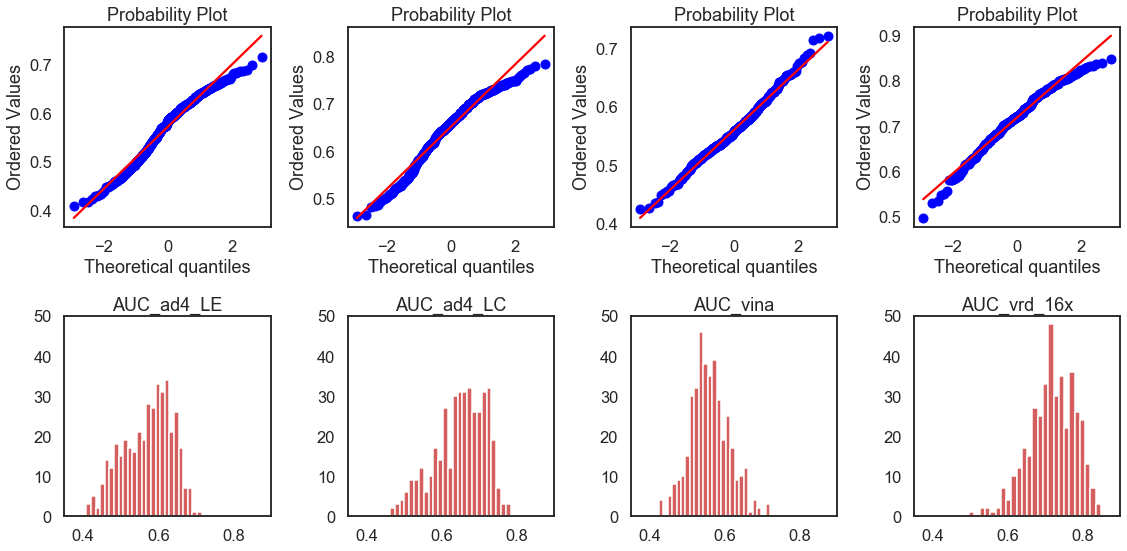

In [161]:
fig, axes = plt.subplots()
fig.set_size_inches(16, 8)

for i, auc_results in enumerate(df_auc_scores.columns):
    plt.subplot(2, 4, i + 1)
    stats.probplot(df_auc_scores[auc_results], dist = "norm", plot=pylab)
    plt.subplot(2, 4, i + 5)
    plt.hist(df_auc_scores[auc_results], bins= 25)
    plt.xlim((0.35, 0.9))
    plt.ylim((0, 50))
    plt.title(auc_results)
fig.tight_layout()  
plt.show()

## Homocedasticidad

In [169]:
# Test de levene para evaluar homocedasticidad en muestras no normales
stats.levene(*df_auc_scores.T.values,  center="median")

LeveneResult(statistic=11.01377348278758, pvalue=3.6973467468158526e-07)

In [ ]:
### Preuab de Kruskal-Walis
# https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/

In [170]:
stats.kruskal(*df_auc_scores.T.values)

KruskalResult(statistic=849.9075803377553, pvalue=6.487089205904422e-184)

In [172]:
stats.friedmanchisquare(*df_auc_scores.T.values)

FriedmanchisquareResult(statistic=940.6675789997512, pvalue=1.335825318410688e-203)

4